# Podcast Review Summarization and Sentiment Analysis

## Data Collection and Preprocessesing 

In [1]:
import pandas as pd
import json
#step1 loading data
def load_json_lines(filepath):
    data = []
    with open(filepath, 'r') as f:
        for line in f:
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError:
                continue
    return pd.DataFrame(data)

    

In [2]:
import os
import json
data_dir = '/Users/yashvikommidi/Downloads/archive-2/'
reviews_df = load_json_lines(os.path.join(data_dir, 'reviews.json'))
podcasts_df = load_json_lines(os.path.join(data_dir, 'podcasts.json'))
categories_df = load_json_lines(os.path.join(data_dir, 'categories.json'))


In [3]:
#step 1
print("Reviews:", reviews_df.columns)
print("Podcasts:", podcasts_df.columns)
print("Categories:", categories_df.columns)


Reviews: Index(['podcast_id', 'title', 'content', 'rating', 'author_id', 'created_at'], dtype='object')
Podcasts: Index(['podcast_id', 'itunes_id', 'slug', 'itunes_url', 'title', 'author',
       'description', 'average_rating', 'ratings_count', 'scraped_at'],
      dtype='object')
Categories: Index(['podcast_id', 'itunes_id', 'category'], dtype='object')


In [4]:
# Step 2: Merging reviews with podcasts
reviews_podcasts = pd.merge(
    reviews_df,
    podcasts_df,
    on='podcast_id',
    suffixes=('_review', '_podcast')
)

# Step 3: Merging with categories
final_merged = pd.merge(
    reviews_podcasts,
    categories_df,
    on='podcast_id',
    how='left'  # Keeping all merged reviews even if no category
)

# Step 4: Saving the merged dataset
final_merged.to_json('final_merged_full.json', orient='records', lines=True)
final_merged.to_csv('final_merged_full.csv', index=False)

# Step 5: Quick preview of final merged dataset
print(" Final merged dataset shape:", final_merged.shape)
print(final_merged.head(2))


 Final merged dataset shape: (785, 17)
                         podcast_id   title_review  \
0  a33a11a0bf8387ca729adf249c8a98db  Great podcast   
1  a33a11a0bf8387ca729adf249c8a98db  Great podcast   

                                             content  rating        author_id  \
0  Been binge listening to all these podcasts and...       5  3dec76c7d97bf1e   
1  Been binge listening to all these podcasts and...       5  3dec76c7d97bf1e   

               created_at itunes_id_x                   slug  \
0  2019-06-14 13:16:47+00  1451439679  i-crush-barbecue-show   
1  2019-06-14 13:16:47+00  1451439679  i-crush-barbecue-show   

                                          itunes_url          title_podcast  \
0  https://podcasts.apple.com/us/podcast/i-crush-...  I Crush Barbecue Show   
1  https://podcasts.apple.com/us/podcast/i-crush-...  I Crush Barbecue Show   

          author                                        description  \
0  icrushbbqshow  Barbecue Enthusiast and Host Abe D

In [5]:
# Dropping rows where review content is missing
final_merged = final_merged.dropna(subset=['content'])

# Dropping exact duplicate reviews
final_merged = final_merged.drop_duplicates(subset=['podcast_id', 'content'])

# Normalizing text
final_merged['content'] = final_merged['content'].astype(str).str.strip()

print(" Final cleaned dataset shape:", final_merged.shape)


 Final cleaned dataset shape: (297, 17)


In [6]:
#printing shape 
print("Merged reviews and podcasts:", reviews_podcasts.shape)
print("Final merged with categories:", final_merged.shape)


Merged reviews and podcasts: (297, 15)
Final merged with categories: (297, 17)


# Exploratory Data Analysis (EDA)

In [7]:
#finding count of missing values
missing = final_merged.isnull().sum()
print(" Missing values:\n", missing[missing > 0])


 Missing values:
 description     1
itunes_id_y    15
category       15
dtype: int64


In [8]:
#printing unique podcasts and categories
print("Unique podcasts:", final_merged['title_podcast'].nunique())
print("Unique categories:", final_merged['category'].nunique())


Unique podcasts: 31
Unique categories: 22


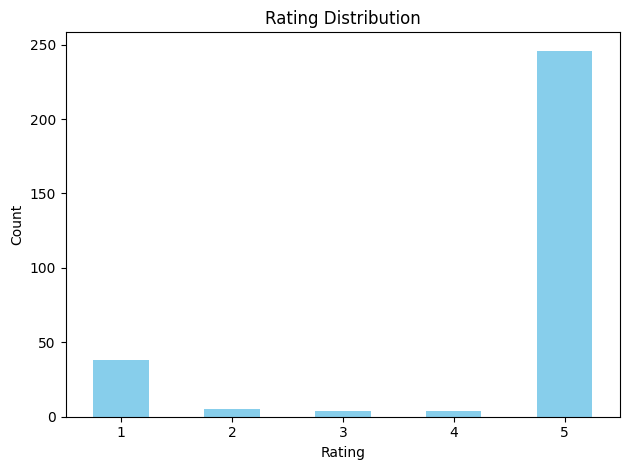

In [9]:
import matplotlib.pyplot as plt

#barplot
final_merged['rating'].value_counts().sort_index().plot(
    kind='bar', color='skyblue', title='Rating Distribution'
)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [10]:
#printing top 10 categories
category_counts = final_merged['category'].value_counts().head(10)
print("Top 10 Categories:\n", category_counts)


Top 10 Categories:
 category
health-fitness                       56
arts-visual-arts                     50
education-how-to                     42
society-culture                      22
news                                 18
sports-wilderness                    17
tv-film                              12
business-careers                     12
health-fitness-alternative-health    11
sports-football                       8
Name: count, dtype: int64


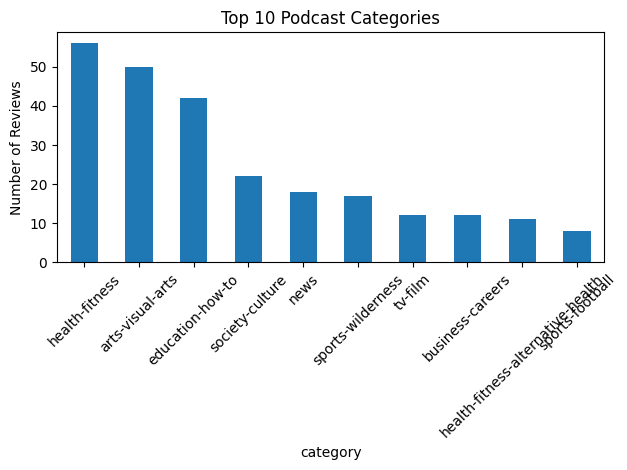

In [11]:

#graph for top 10 podcast categories
category_counts.plot(kind='bar', title='Top 10 Podcast Categories')
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


 Most Reviewed Podcasts:
 title_podcast
The Daily Boost | Daily Coaching and Motivation                                                                                  56
The Oatley Academy ArtCast                                                                                                       50
Her Money Matters                                                                                                                42
Rekt Podcast                                                                                                                     18
Outside Voices Podcast                                                                                                           17
Last Week at the Movies Podcast                                                                                                  12
F*ck Like a Woman                                                                                                                12
Emprendedores Digitales |Marketing D

/var/folders/90/fkyv698s5_xcxv5vrkz1vqk40000gn/T/ipykernel_34156/3879414836.py:8: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


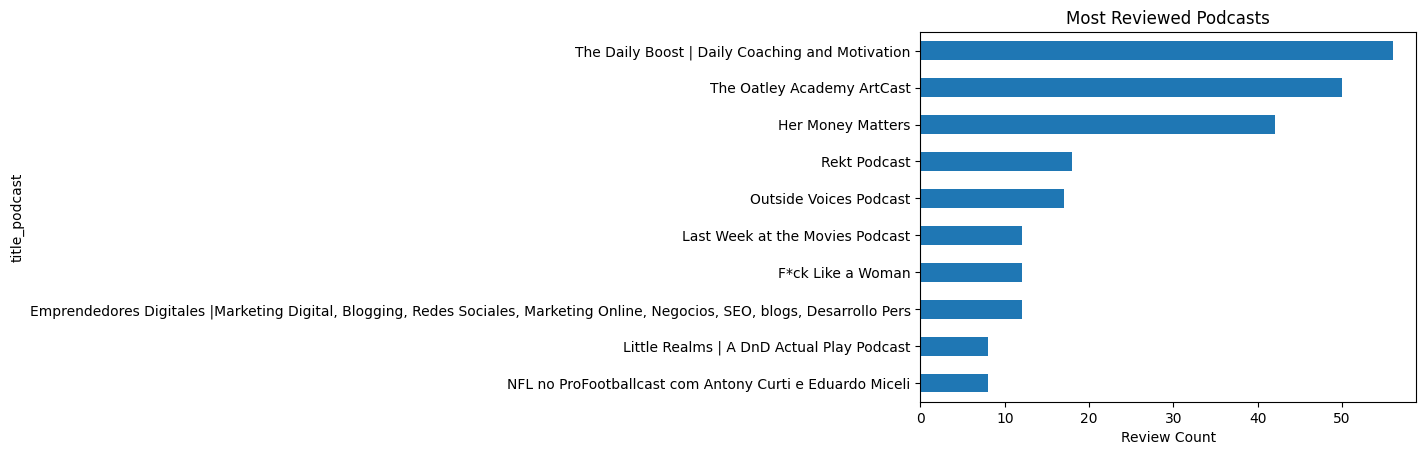

In [12]:

#graph for most reviewed podcasts 
top_podcasts = final_merged['title_podcast'].value_counts().head(10)
print(" Most Reviewed Podcasts:\n", top_podcasts)

top_podcasts.plot(kind='barh', title='Most Reviewed Podcasts')
plt.xlabel("Review Count")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


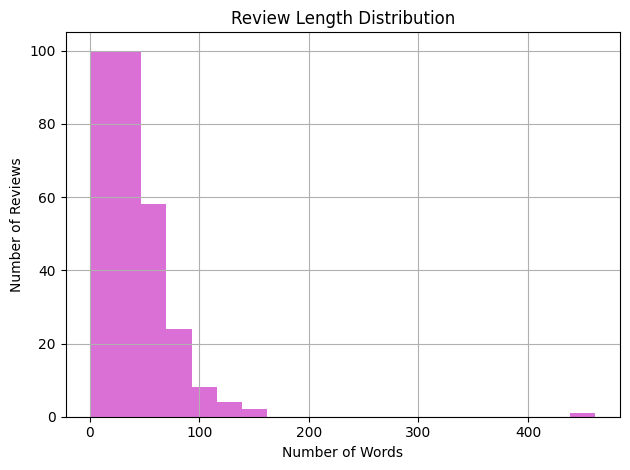

In [13]:
#graph for review length distribution 
final_merged['review_length'] = final_merged['content'].apply(lambda x: len(str(x).split()))
final_merged['review_length'].hist(bins=20, color='orchid')
plt.title("Review Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()


# VADER Sentiment 

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a simple but powerful rule-based model for sentiment analysis. It works really well on short texts like social media posts, comments, and reviews.

VADER doesn’t need any training like it uses a dictionary of words labeled with sentiment scores. It also understands things like capitalization ("GREAT" is stronger than "great"), punctuation (like "!!!"), emojis, and even slang (like "meh" or "awesome").

In this project, VADER helped us quickly classify podcast reviews as positive, neutral, or negative based on the overall tone of the text.

In [14]:
pip install vaderSentiment


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [15]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initializing the VADER analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to classify sentiment
def classify_vader(text):
    score = analyzer.polarity_scores(str(text))['compound']
    if score >= 0.2:
        return 'positive'
    elif score <= -0.2:
        return 'negative'
    else:
        return 'neutral'

# Applying to your dataset
final_merged['vader_sentiment'] = final_merged['content'].apply(classify_vader)

# Previewing the result
print(final_merged[['content', 'rating', 'vader_sentiment']].head())


                                              content  rating vader_sentiment
0   Been binge listening to all these podcasts and...       5        positive
2   This podcast is really unique because we are a...       5        positive
5                                  This is so great!!       5        positive
8   I am hooked... I’m looking forward to learning...       5         neutral
11  As a big fan of horror, sci-fi, and fiction an...       5        positive


In [16]:
# Normalize sentiment labels to lowercase just in case
final_merged['vader_sentiment'] = final_merged['vader_sentiment'].str.lower()


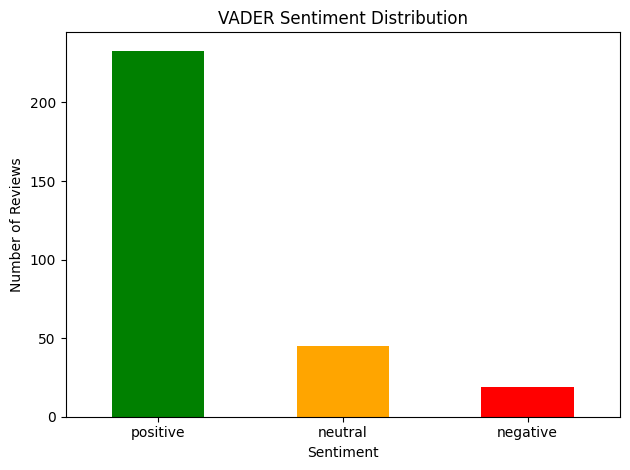

In [17]:


import matplotlib.pyplot as plt

#graph for vader sentiment 
final_merged['vader_sentiment'].value_counts().plot(
    kind='bar', color=['green', 'orange', 'red'], title='VADER Sentiment Distribution'
)
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# BERT Sentiment Analysis

BERT is a smart language model created by Google that can understand the meaning of a sentence by looking at all the words around it not just one at a time. This helps it really get what someone is trying to say, even when the language is tricky or emotional.

In this project, we have used a ready-to-go BERT model to check how people feel in their podcast reviews. It tells us whether each review sounds positive, negative, or neutral. Since BERT is really good at picking up on context and tone, it does a better job than simpler models when reviews are lo

In [18]:
pip install transformers torch


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [19]:
from transformers import pipeline

# Loading pre-trained sentiment pipeline
bert_pipeline = pipeline("sentiment-analysis")

# Using a subset for testing
subset = final_merged.head(100).copy()

# Applying BERT sentiment classification
subset['bert_sentiment'] = subset['content'].apply(lambda x: bert_pipeline(str(x))[0]['label'].lower())

# Previewing
print(subset[['content', 'vader_sentiment', 'bert_sentiment']].head())


/Users/yashvikommidi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/yashvikommidi/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0


                                              content vader_sentiment  \
0   Been binge listening to all these podcasts and...        positive   
2   This podcast is really unique because we are a...        positive   
5                                  This is so great!!        positive   
8   I am hooked... I’m looking forward to learning...         neutral   
11  As a big fan of horror, sci-fi, and fiction an...        positive   

   bert_sentiment  
0        positive  
2        positive  
5        positive  
8        positive  
11       positive  


 VADER and BERT agree on 87.00% of the first 100 reviews.


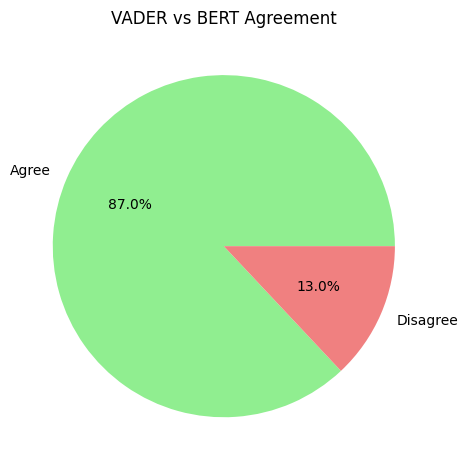

In [20]:
# Normalizing VADER labels to lowercase
subset['vader_norm'] = subset['vader_sentiment'].str.lower()

# Comparing agreement
subset['agree'] = subset['vader_norm'] == subset['bert_sentiment']
agreement_rate = subset['agree'].mean() * 100

print(f" VADER and BERT agree on {agreement_rate:.2f}% of the first 100 reviews.")

# Visualizing
subset['agree'].value_counts().plot(
    kind='pie', labels=['Agree', 'Disagree'], autopct='%1.1f%%',
    colors=['lightgreen', 'lightcoral'], title='VADER vs BERT Agreement'
)
plt.ylabel('')
plt.tight_layout()
plt.show()


In [21]:
def rating_to_label(rating):
    if rating in [1, 2]:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    elif rating in [4, 5]:
        return 'positive'
    else:
        return None

# Applying to the subset used for BERT
subset['true_sentiment'] = subset['rating'].apply(rating_to_label)


In [22]:
from sklearn.metrics import classification_report, confusion_matrix

# Dropping missing or uncertain
eval_df = subset.dropna(subset=['true_sentiment', 'bert_sentiment'])
eval_df = eval_df[eval_df['bert_sentiment'] != 'uncertain']  # Optional

# checking shape
print(" Samples used:", eval_df.shape[0])


 Samples used: 100


BERT vs Rating (Pseudo Ground Truth):
              precision    recall  f1-score   support

    negative      0.333     1.000     0.500         2
     neutral      0.000     0.000     0.000         1
    positive      1.000     0.969     0.984        97

    accuracy                          0.960       100
   macro avg      0.444     0.656     0.495       100
weighted avg      0.977     0.960     0.965       100



/Users/yashvikommidi/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yashvikommidi/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yashvikommidi/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

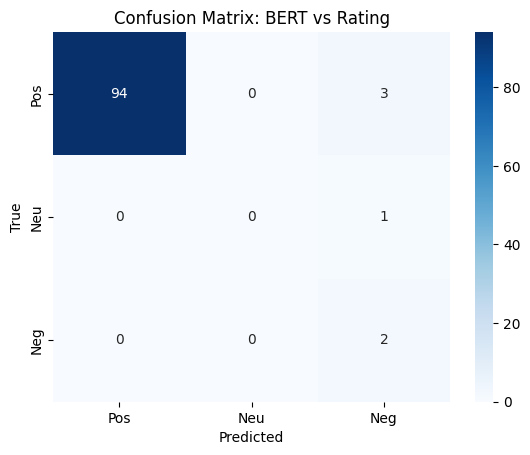

In [23]:
y_true = eval_df['true_sentiment']
y_pred = eval_df['bert_sentiment']

# Printing classification report
print("BERT vs Rating (Pseudo Ground Truth):")
print(classification_report(y_true, y_pred, digits=3))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred, labels=['positive', 'neutral', 'negative'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pos', 'Neu', 'Neg'], yticklabels=['Pos', 'Neu', 'Neg'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix: BERT vs Rating')
plt.show()


# Abstractive Summarization with T5

T5 is a language model from Google that’s trained to write like a human. Instead of just picking sentences from a review, it actually rewrites the content in a shorter, more natural way just like how we’d explain something to a friend.

In this project, we used T5 to take long podcast reviews and turn them into short, easy-to-read summaries. This helps podcast creators quickly understand what people are saying without reading every word.

In [24]:
pip install transformers


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [25]:
from transformers import pipeline

# Loading summarization pipeline using T5
t5_summarizer = pipeline("summarization", model="t5-small")


Device set to use mps:0


In [26]:
def t5_summary(text, max_input_words=150):
    text = text.strip().replace('\n', ' ')
    words = text.split()
    input_word_count = len(words)

    if input_word_count == 0:
        return ""

    if input_word_count > max_input_words:
        text = " ".join(words[:max_input_words])

    # Max summary length is half the input
    max_out = max(10, int(len(text.split()) * 0.5))

    try:
        summary = t5_summarizer("summarize: " + text, max_length=max_out, min_length=10, do_sample=False)
        return summary[0]['summary_text']
    except:
        return "Error"


In [27]:
# Reusing grouped reviews if available; if not, create it:
grouped_reviews = final_merged.groupby('podcast_id')['content'].apply(lambda x: " ".join(x)).reset_index()

# Generating T5 summaries
grouped_reviews['t5_summary'] = grouped_reviews['content'].apply(t5_summary)


Your max_length is set to 10, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)
Your max_length is set to 10, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


In [28]:


# Loading sentiment pipeline
bert_pipeline = pipeline("sentiment-analysis")


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0


In [29]:
final_with_summary = pd.merge(
    final_merged,
    grouped_reviews[['podcast_id', 't5_summary']],
    on='podcast_id',
    how='left'
)


# TextRank Extractive Summarization

TextRank is like Google’s PageRank but for sentences instead of websites. It looks through a review and finds the most important sentences based on how they relate to each other.

In this project, we used TextRank to pull out the key sentences from a bunch of long podcast reviews. It doesn’t rewrite the text it just picks out the highlights so you can quickly get the main idea without reading everything.

In [30]:
!pip install scikit-learn networkx



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [31]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

# sentence splitter (no nltk)
def split_sentences(text):
    sentences = re.split(r'(?<=[.!?])\s+', text.strip())
    return [s for s in sentences if len(s.split()) > 3]  

def textrank_no_nltk(text, num_sentences=3):
    sentences = split_sentences(text)
    if len(sentences) <= num_sentences:
        return " ".join(sentences)
    
    tfidf = TfidfVectorizer().fit_transform(sentences)
    sim_matrix = cosine_similarity(tfidf)
    
    graph = nx.from_numpy_array(sim_matrix)
    scores = nx.pagerank(graph)

    ranked = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)
    summary = " ".join([s for _, s in ranked[:num_sentences]])
    return summary


In [32]:

# Applying NLTK-free TextRank summarizer
grouped_reviews['textrank_summary'] = grouped_reviews['content'].apply(textrank_no_nltk)

# Merging into main DataFrame
final_with_summary = pd.merge(final_merged, grouped_reviews[['podcast_id', 'textrank_summary']], on='podcast_id', how='left')


In [33]:
print(final_with_summary[['title_podcast', 'category', 'textrank_summary']].drop_duplicates().head(3))


                   title_podcast   category  \
0          I Crush Barbecue Show  arts-food   
1  Twin Talk with the King Twins       arts   
4                   Tall Tale TV    fiction   

                                    textrank_summary  
0  Been binge listening to all these podcasts and...  
1  This podcast is really unique because we are a...  
4  As a big fan of horror, sci-fi, and fiction an...  


In [34]:
final_with_summary.to_csv("podcast_review_summaries.csv", index=False)
print(" Saved as podcast_review_summaries.csv")


 Saved as podcast_review_summaries.csv


In [35]:
print(final_with_summary.columns)


Index(['podcast_id', 'title_review', 'content', 'rating', 'author_id',
       'created_at', 'itunes_id_x', 'slug', 'itunes_url', 'title_podcast',
       'author', 'description', 'average_rating', 'ratings_count',
       'scraped_at', 'itunes_id_y', 'category', 'review_length',
       'vader_sentiment', 'textrank_summary'],
      dtype='object')


In [36]:


# checking if the column exists
print(grouped_reviews.columns)  # Make sure 't5_summary' is in the list


Index(['podcast_id', 'content', 't5_summary', 'textrank_summary'], dtype='object')


In [37]:

final_with_summary = pd.merge(final_merged, grouped_reviews[['podcast_id', 't5_summary']], on='podcast_id', how='left')


In [38]:
print(final_with_summary.columns)

Index(['podcast_id', 'title_review', 'content', 'rating', 'author_id',
       'created_at', 'itunes_id_x', 'slug', 'itunes_url', 'title_podcast',
       'author', 'description', 'average_rating', 'ratings_count',
       'scraped_at', 'itunes_id_y', 'category', 'review_length',
       'vader_sentiment', 't5_summary'],
      dtype='object')


In [39]:
# Grouping and summarizing
grouped_textrank = final_with_summary.groupby('podcast_id')['content'].apply(lambda x: " ".join(x)).reset_index()
grouped_textrank['textrank_summary'] = grouped_textrank['content'].apply(textrank_no_nltk)

# Merging back into final_with_summary
final_with_summary = pd.merge(
    final_with_summary,
    grouped_textrank[['podcast_id', 'textrank_summary']],
    on='podcast_id',
    how='left'
)


In [40]:
export_df = final_with_summary.groupby('podcast_id')['content'].apply(lambda x: " ".join(x)).reset_index()

export_df = export_df.merge(
    final_with_summary[['podcast_id', 'title_podcast', 'category', 'textrank_summary', 't5_summary']].drop_duplicates(),
    on='podcast_id',
    how='left'
)

# Save it
export_df.to_csv("podcast_reviews_with_summaries.csv", index=False)
print(" File saved as podcast_reviews_with_summaries.csv")


 File saved as podcast_reviews_with_summaries.csv


# ROUGE Evaluation for Summaries

ROUGE (Recall-Oriented Understudy for Gisting Evaluation) is a way to check how good a summary is by comparing it to a reference (usually the original text). It looks at the overlap of words and phrases between the summary and the original content.

In our project, we used ROUGE to see how well the TextRank and T5 summaries captured the key ideas from the original podcast reviews. Higher ROUGE scores mean the summary does a better job at preserving important information.

In [41]:
pip install rouge-score


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [42]:
from rouge_score import rouge_scorer

# Initializing ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# writing Function to compute average ROUGE scores for a list of summaries
def compute_rouge_scores(references, candidates):
    rouge1_scores, rouge2_scores, rougeL_scores = [], [], []

    for ref, cand in zip(references, candidates):
        try:
            scores = scorer.score(ref, cand)
            rouge1_scores.append(scores['rouge1'].fmeasure)
            rouge2_scores.append(scores['rouge2'].fmeasure)
            rougeL_scores.append(scores['rougeL'].fmeasure)
        except:
            continue  # skip problematic rows

    return {
        "ROUGE-1": np.mean(rouge1_scores),
        "ROUGE-2": np.mean(rouge2_scores),
        "ROUGE-L": np.mean(rougeL_scores)
    }


In [43]:
import numpy as np

In [44]:
# Getting original full reviews and corresponding summaries
references = final_with_summary['content'].astype(str).tolist()
t5_summaries = final_with_summary['t5_summary'].astype(str).tolist()
textrank_summaries = final_with_summary['textrank_summary'].astype(str).tolist()

# Computing ROUGE scores
rouge_t5 = compute_rouge_scores(references, t5_summaries)
rouge_textrank = compute_rouge_scores(references, textrank_summaries)

print("ROUGE Scores - T5 Abstractive Summary")
for k, v in rouge_t5.items():
    print(f"{k}: {v:.4f}")

print("\nROUGE Scores - TextRank Extractive Summary")
for k, v in rouge_textrank.items():
    print(f"{k}: {v:.4f}")


ROUGE Scores - T5 Abstractive Summary
ROUGE-1: 0.2036
ROUGE-2: 0.0766
ROUGE-L: 0.1590

ROUGE Scores - TextRank Extractive Summary
ROUGE-1: 0.2828
ROUGE-2: 0.1276
ROUGE-L: 0.2066


# Bar Plot: Average Review Length vs. Summary Length

This plot shows how much we were able to shorten the original reviews using summarization. We compared the average word count of full reviews with the summaries generated by TextRank and T5 for each podcast.

The goal was to see if the summaries were meaningfully shorter but still captured the main points. As expected, both summary methods reduced the length a lot—T5 usually gave shorter and more concise summaries.

/var/folders/90/fkyv698s5_xcxv5vrkz1vqk40000gn/T/ipykernel_34156/268752947.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


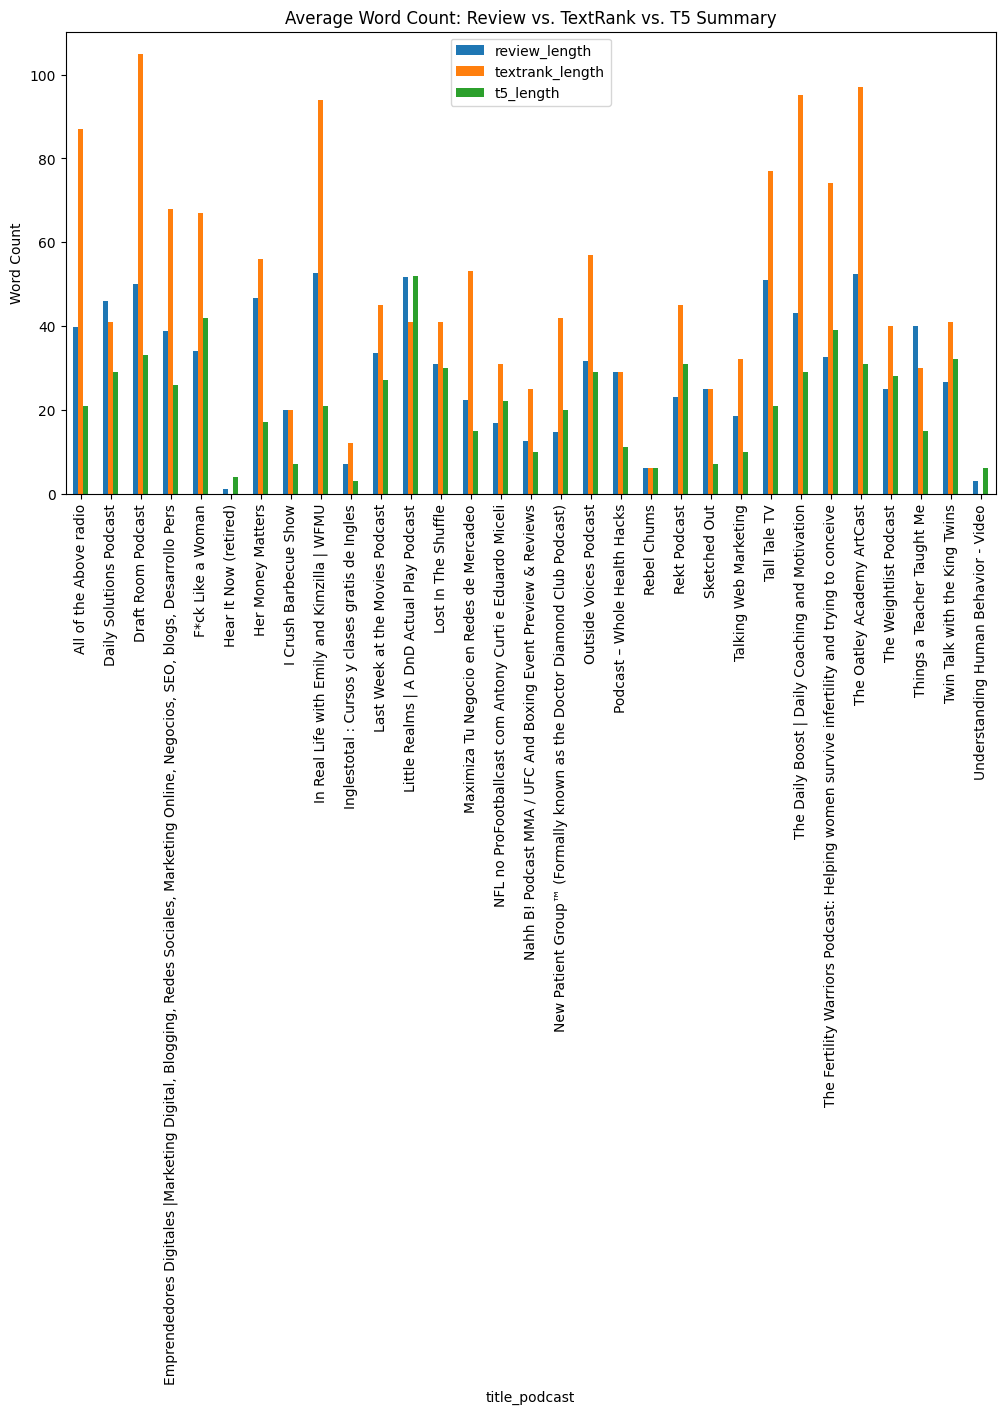

In [45]:
# Compute original and summary lengths
final_with_summary['review_length'] = final_with_summary['content'].apply(lambda x: len(str(x).split()))
final_with_summary['textrank_length'] = final_with_summary['textrank_summary'].apply(lambda x: len(str(x).split()))
final_with_summary['t5_length'] = final_with_summary['t5_summary'].apply(lambda x: len(str(x).split()))

# Average lengths by podcast
summary_lengths = final_with_summary.groupby('title_podcast')[['review_length', 'textrank_length', 't5_length']].mean().reset_index()

# Plot
import matplotlib.pyplot as plt

summary_lengths.set_index('title_podcast').plot(kind='bar', figsize=(12,6))
plt.title('Average Word Count: Review vs. TextRank vs. T5 Summary')
plt.ylabel('Word Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


both summarization techniques significantly reduce the word count while keeping key ideas intact. T5 usually gives even shorter summaries because it rewrites the content, while TextRank pulls exact sentences from the original.

In [46]:
sample_podcasts = final_with_summary['title_podcast'].dropna().unique()[:3]

#Sample and display summaries for 3 example podcasts.

for podcast in sample_podcasts:
    sample = final_with_summary[final_with_summary['title_podcast'] == podcast].iloc[0]
    print(f"\n {sample['title_podcast']} | Category: {sample['category']}")
    print("-" * 60)
    print(" Extractive (TextRank):")
    print(sample['textrank_summary'])
    print("\nAbstractive (T5):")
    print(sample['t5_summary'])
    print("=" * 60)



 I Crush Barbecue Show | Category: arts-food
------------------------------------------------------------
 Extractive (TextRank):
Been binge listening to all these podcasts and love them all. Lots of variety and have thoroughly enjoyed them all.

Abstractive (T5):
been binge listening to all these podcast

 Twin Talk with the King Twins | Category: arts
------------------------------------------------------------
 Extractive (TextRank):
This podcast is really unique because we are able to see what life is like living in NYC, having a twin, being in college, etc. Also, their viewpoints on life are fascinating, making for a great podcast. This is so great!!

Abstractive (T5):
this podcast is really unique because we are able to see what life is like living in NYC, having a twin, being in college, etc. they make it seem as if you

 Tall Tale TV | Category: fiction
------------------------------------------------------------
 Extractive (TextRank):
As a big fan of horror, sci-fi, and fict

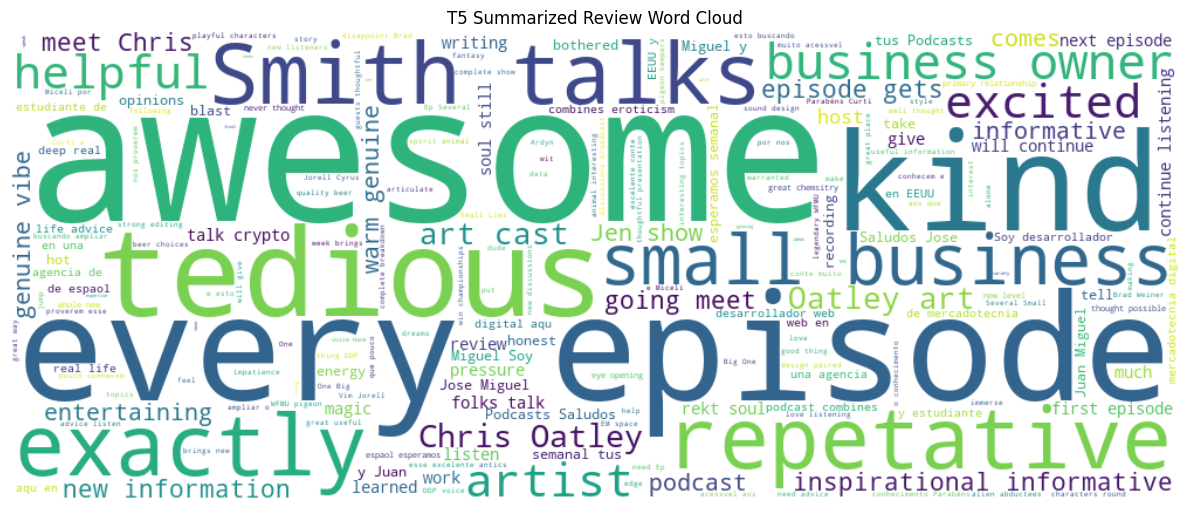

In [47]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combining all summaries into one big string
text = " ".join(final_with_summary['t5_summary'].dropna())

# Creating WordCloud
wordcloud = WordCloud(width=1000, height=400, background_color='white').generate(text)

# Displaying
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("T5 Summarized Review Word Cloud")
plt.tight_layout()
plt.show()


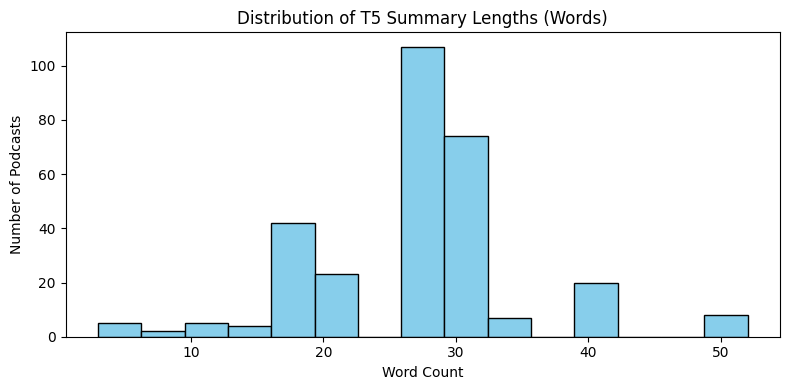

In [48]:
# Calculating length
final_with_summary['t5_summary_length'] = final_with_summary['t5_summary'].apply(lambda x: len(str(x).split()))

# Plotting
final_with_summary['t5_summary_length'].plot.hist(bins=15, color='skyblue', edgecolor='black', figsize=(8, 4))
plt.title("Distribution of T5 Summary Lengths (Words)")
plt.xlabel("Word Count")
plt.ylabel("Number of Podcasts")
plt.tight_layout()
plt.show()


# Sentiment Distribution (Overall)

To understand how users feel about the podcasts in general, we analyzed the tone of each review using the VADER sentiment analysis model. This model labeled each review as positive, neutral, or negative based on the words and expressions used.

We then plotted these results to see the overall emotional trend in the reviews. This helped us quickly identify whether most listeners had a good experience, were indifferent, or expressed dissatisfaction with the podcasts.

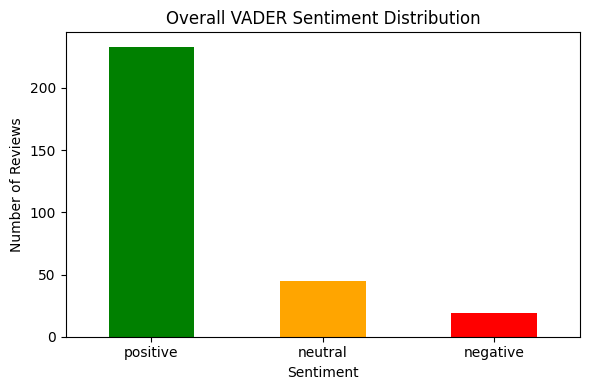

In [49]:

import matplotlib.pyplot as plt

final_with_summary['vader_sentiment'].value_counts().plot(
    kind='bar',
    color=['green', 'orange', 'red'],
    title='Overall VADER Sentiment Distribution',
    figsize=(6,4)
)
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# Sentiment by Podcast Category

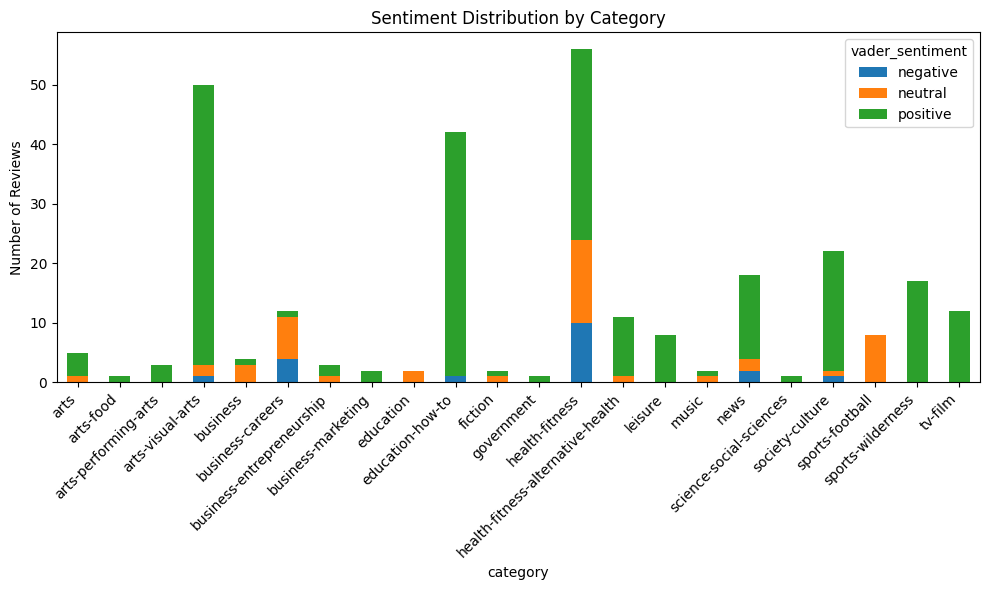

In [50]:
sentiment_by_category = final_with_summary.groupby('category')['vader_sentiment'].value_counts().unstack().fillna(0)

#plotting sentiment by podcast category
sentiment_by_category.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    title='Sentiment Distribution by Category'
)
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Word Clouds by Sentiment

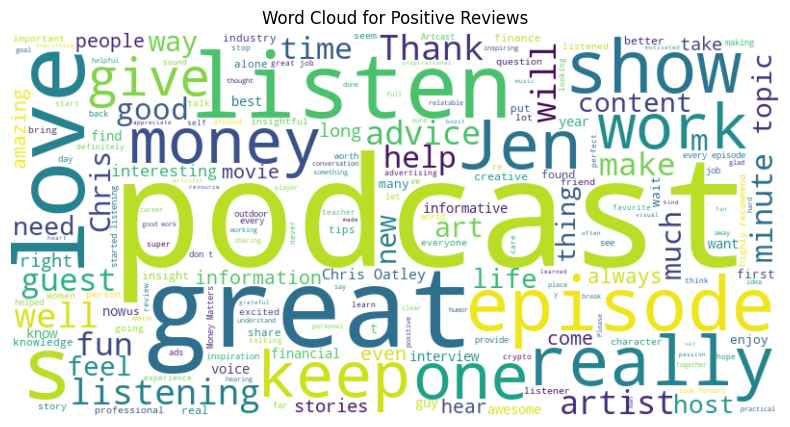

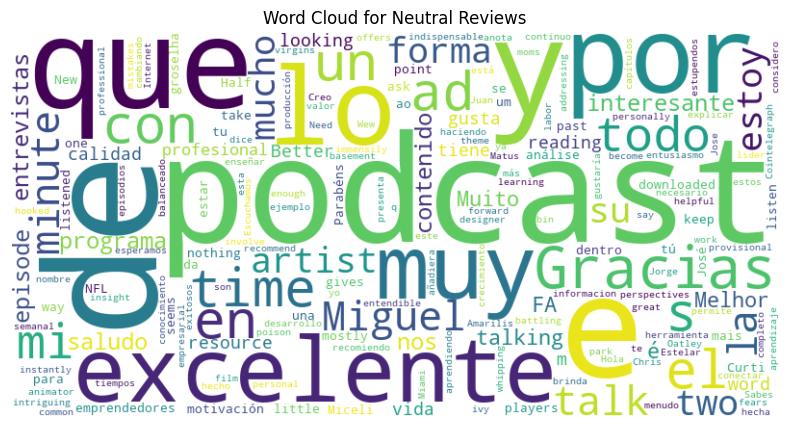

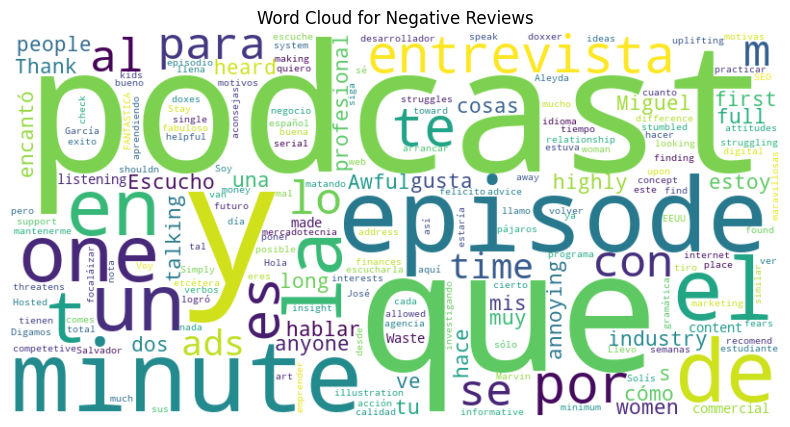

In [51]:
from wordcloud import WordCloud

#plotting wordcloud by sentiment
for sentiment in ['positive', 'neutral', 'negative']:
    text = " ".join(final_with_summary[final_with_summary['vader_sentiment'].str.lower() == sentiment]['content'].dropna())
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment.capitalize()} Reviews')
    plt.show()


# Average Ratings by Category

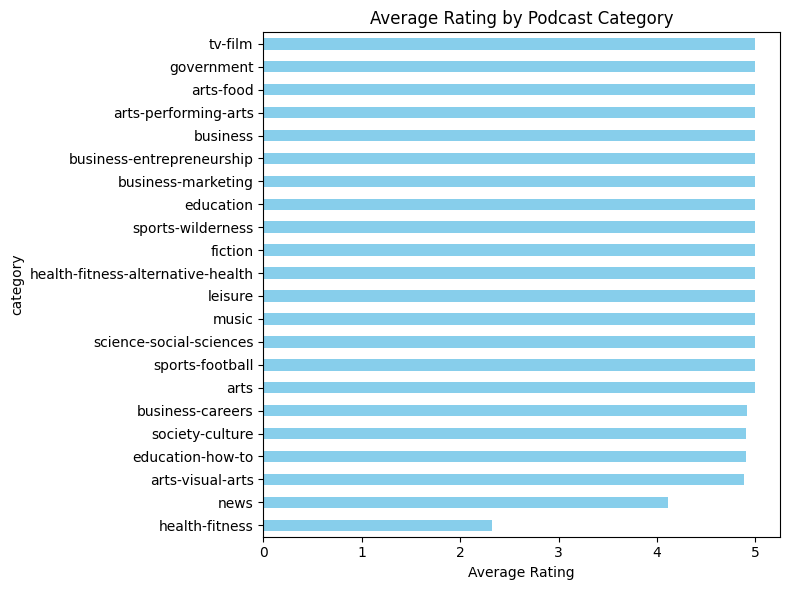

In [52]:
avg_rating = final_with_summary.groupby('category')['rating'].mean().sort_values()

#plotting average rating based on categories
avg_rating.plot(
    kind='barh',
    color='skyblue',
    figsize=(8, 6),
    title='Average Rating by Podcast Category'
)
plt.xlabel('Average Rating')
plt.tight_layout()
plt.show()


In [53]:
print(final_with_summary.columns)


Index(['podcast_id', 'title_review', 'content', 'rating', 'author_id',
       'created_at', 'itunes_id_x', 'slug', 'itunes_url', 'title_podcast',
       'author', 'description', 'average_rating', 'ratings_count',
       'scraped_at', 'itunes_id_y', 'category', 'review_length',
       'vader_sentiment', 't5_summary', 'textrank_summary', 'textrank_length',
       't5_length', 't5_summary_length'],
      dtype='object')


In [54]:
# Assuming 'subset' is the DataFrame where you computed bert_sentiment
# And it came from final_with_summary.head(100)

final_with_summary.loc[subset.index, 'bert_sentiment'] = subset['bert_sentiment']


In [55]:
# Selecting relevant columns
results_df = final_with_summary[[
    'podcast_id', 'title_podcast', 'category', 'content', 'rating',
    'vader_sentiment', 'bert_sentiment', 'textrank_summary', 't5_summary'
]]

# Saving result to a CSV
results_df.to_csv('podcast_review_analysis_results.csv', index=False)

print(" Results saved to 'podcast_review_analysis_results.csv'")


 Results saved to 'podcast_review_analysis_results.csv'
